In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import os

sys.path.append('../')

from functions import *
from functions.preprocessing import *
from functions.swing_points import *
from functions.fvg import *

quandl_api_key = '_umNYuQHdkCgs9Rcm4Fv'

In [3]:
df = pd.read_csv('../data/GLBX-20231023-KQS5VQRSDH/glbx-mdp3-20170521-20231022.ohlcv-1m.csv')

In [4]:
df_es = df[df.symbol.str.startswith('ES')].drop(columns=['rtype', 'publisher_id', 'instrument_id', 'symbol'])
df_es['ts_event'] = pd.to_datetime(df_es.ts_event).dt.tz_convert('America/New_York')
df_es['datetime'] = df_es.ts_event
df_es.drop(columns='ts_event', inplace=True)
df_es.set_index('datetime', inplace=True)

# remove duplicated candles by keeping only the ones with the higher volume (those seem to be the right ones)
df_es = df_es.sort_values(by=['datetime', 'volume'], ascending=[True, False])
df_es = df_es[~df_es.index.duplicated(keep='first')]
df_es = df_es[df_es.open >= 2000]

In [5]:
df_nq = df[df.symbol.str.startswith('NQ')].drop(columns=['rtype', 'publisher_id', 'instrument_id', 'symbol'])
df_nq['ts_event'] = pd.to_datetime(df_nq.ts_event).dt.tz_convert('America/New_York')
df_nq['datetime'] = df_nq.ts_event
df_nq.drop(columns='ts_event', inplace=True)
df_nq.set_index('datetime', inplace=True)

# remove duplicated candles by keeping only the ones with the higher volume (those seem to be the right ones)
df_nq = df_nq.sort_values(by=['datetime', 'volume'], ascending=[True, False])
df_nq = df_nq[~df_nq.index.duplicated(keep='first')]

In [6]:
df_ym = df[df.symbol.str.startswith('YM')].drop(columns=['rtype', 'publisher_id', 'instrument_id', 'symbol'])
df_ym['ts_event'] = pd.to_datetime(df_ym.ts_event).dt.tz_convert('America/New_York')
df_ym['datetime'] = df_ym.ts_event
df_ym.drop(columns='ts_event', inplace=True)
df_ym.set_index('datetime', inplace=True)

# remove duplicated candles by keeping only the ones with the higher volume (those seem to be the right ones)
df_ym = df_ym.sort_values(by=['datetime', 'volume'], ascending=[True, False])
df_ym = df_ym[~df_ym.index.duplicated(keep='first')]

In [7]:
df_list = []
for df in [df_es, df_nq, df_ym]:
    lookback = 20
    timeframes = ['1T', '5T', '15T', '1H', '4H', '1B']
    timeframes_fvg = ['1T', '5T', '15T', '1H', '4H', '1B']
    df = identify_swing_points_optimized(df, timeframes, get_swing_values=True, interpolation_method='None')
    df = identify_fair_value_gaps_optimized(df, timeframes_fvg, get_high_low=True)
    df_list.append(df)

In [8]:
df = pd.merge(df_list[0], df_list[1], 'inner', 'datetime', suffixes=('_es', '_nq'))
del(df_es)
del(df_nq)

df_list[2].columns = [c + '_ym' for c in df_list[2].columns]
df = pd.merge(df, df_list[2], 'inner', 'datetime')
del(df_ym)

del(df_list)

In [9]:
df = df.assign(
    month=df.index.month,
    day=df.index.day,
    hour=df.index.hour,
    minute=df.index.minute,
    day_of_week=df.index.dayofweek.astype('int8')
)

In [10]:
def add_cyclic_date_features(df, column, max_val):
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_val).astype('float32')
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_val).astype('float32')
    df.drop(columns=column, inplace=True)

add_cyclic_date_features(df, 'month', 12)
add_cyclic_date_features(df, 'day', 31)
add_cyclic_date_features(df, 'hour', 23)
add_cyclic_date_features(df, 'minute', 60)
add_cyclic_date_features(df, 'day_of_week', 6)

In [11]:
# Get weekly open and closes and midnight open
df['weekly_open'] = df.open_es.resample('W-SAT', label='left').first().reindex(df.index, method='ffill')
df['weekly_close'] = df.close_es.resample('W-SAT', label='left').first().shift(1).reindex(df.index, method='ffill')
df['daily_open'] = df.open_es.resample('D', label='left').first().reindex(df.index, method='ffill')

In [20]:
price_cols = df.columns[(df>1).any()]
cyclical_cols = [c for c in df.columns if re.match(r'^.*(_sin|_cos)', c)]
swing_cols = [c for c in df.columns if 'swing' in c]
fvg_cols = [c for c in df.columns if 'fair' in c]
df = df.fillna(0)

In [21]:
import re

# Define the resample timeframes
timeframes = ['1T', '5T', '15T', '1H', '4H', '1B']

import re

resample_cols = {
    '1T': r'((open|high|low|close)_.*)|(swing_1T_.*)|(fair_value_gap_1T)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '5T': r'((open|high|low|close)_.*)|(swing_5T_.*)|(fair_value_gap_5T)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '15T': r'((open|high|low|close)_.*)|(swing_15T_.*)|(fair_value_gap_15T)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '1H': r'((open|high|low|close)_.*)|(swing_1H_.*)|(fair_value_gap_1H)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '4H': r'((open|high|low|close)_.*)|(swing_4H_.*)|(fair_value_gap_4H)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '1B': r'((open|high|low|close)_.*)|(swing_1B_.*)|(fair_value_gap_1B)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
}

aggs = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'swing_.*': 'first',
    'fair_value_gap_.*': lambda x: x[x!=0].iloc[0] if len(x[x!=0]) > 0 else 0,
    'minute.*': 'first',
    'hour.*': 'first',
    'day.*': 'first',
    'month.*': 'first',
    'day_of_week_.*': 'first',
    'weekly_open': 'first',
    'weekly_close': 'first',
    'daily_open': 'first',
    'news_.*' : 'max'
}

keep_cols = {}
for timeframe, regex in resample_cols.items():
    cols = []
    for col in df.columns:
        if re.match(regex, col):
            cols.append(col)
    agg_cols = {}
    for col in cols:
        for agg in aggs:
            if re.match(agg, col):
                agg_cols[col] = aggs[agg]
                break
    keep_cols[timeframe] = agg_cols


In [22]:
#from tsfracdiff import FractionalDifferentiator
#from fracdiff.sklearn import FracdiffStat
import pickle

#df.index = pd.to_datetime(df.index)
#df = df.astype({col: 'float32' for col in df.select_dtypes(include='float64').columns})
#df = df.astype({col: 'int8' for col in df.select_dtypes(include=['int64', 'object']).columns})

for t in timeframes:
    print(t)
    if t == '1T':
        temp = df[[c for c in df.columns if re.match(resample_cols['1T'], c)]].dropna()
    elif t == '4H':
        temp = df.resample(t, offset='2H').agg(keep_cols[t]).dropna()
    else:
        temp = df.resample(t).agg(keep_cols[t]).dropna()
        
    
    #s = FractionalDifferentiator(memoryThreshold=1e-2)
    #s = FracdiffStat()
    #temp.loc[:, price_cols] = s.fit_transform(temp[price_cols])  
    #with open(f'FractionalDifferentiator_{t}.pkl', 'wb') as file:
    #    pickle.dump(s, file)
        
    temp = temp.astype({col: 'float32' for col in temp.select_dtypes(include='float64').columns})
    temp = temp.astype({col: 'int8' for col in temp.select_dtypes(include='int64').columns})
    temp.dropna().to_parquet(f'df_{t}.parquet', index=True)

1T
5T
15T
1H
4H
1B


In [23]:
dfB = pd.read_parquet('df_15T.parquet')

In [24]:
dfB

,open_es,high_es,low_es,close_es,fair_value_gap_15T_es,fair_value_gap_15T_high_es,fair_value_gap_15T_low_es,open_nq,high_nq,low_nq,...,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,day_of_week_sin,day_of_week_cos,weekly_open,weekly_close,daily_open
datetime,,,,,,,,,,,,,,,,,,,,,
2017-05-21 18:00:00-04:00,2381.75,2384.00,2381.00,2382.25,0.0,0.0,0.0,5652.75,5660.50,5651.25,...,-0.440394,-0.979084,0.203456,0.000000e+00,1.000000e+00,-2.449294e-16,1.0,2381.75,0.0,2381.75
2017-05-21 18:15:00-04:00,2382.25,2383.00,2382.00,2382.75,0.0,0.0,0.0,5656.50,5658.75,5656.00,...,-0.440394,-0.979084,0.203456,1.000000e+00,2.832769e-16,-2.449294e-16,1.0,2381.75,0.0,2381.75
2017-05-21 18:30:00-04:00,2382.50,2383.25,2382.25,2383.00,0.0,0.0,0.0,5658.50,5659.50,5657.50,...,-0.440394,-0.979084,0.203456,5.665539e-16,-1.000000e+00,-2.449294e-16,1.0,2381.75,0.0,2381.75
2017-05-21 18:45:00-04:00,2383.00,2384.00,2380.75,2383.00,0.0,0.0,0.0,5659.25,5661.00,5658.50,...,-0.440394,-0.979084,0.203456,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.0,2381.75,0.0,2381.75
2017-05-21 19:00:00-04:00,2383.00,2383.25,2381.75,2381.75,0.0,0.0,0.0,5658.50,5659.00,5655.50,...,-0.440394,-0.887885,0.460065,0.000000e+00,1.000000e+00,-2.449294e-16,1.0,2381.75,0.0,2381.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-20 15:45:00-04:00,4252.00,4256.00,4247.25,4248.50,-1.0,-1.0,-1.0,14675.00,14686.75,14651.75,...,-0.612106,-0.816970,-0.576680,-1.000000e+00,-1.836970e-16,-8.660254e-01,-0.5,4356.75,4310.5,4296.50
2023-10-20 16:00:00-04:00,4248.50,4250.00,4245.00,4245.00,0.0,0.0,0.0,14661.25,14669.00,14647.25,...,-0.612106,-0.942261,-0.334880,0.000000e+00,1.000000e+00,-8.660254e-01,-0.5,4356.75,4310.5,4296.50
2023-10-20 16:15:00-04:00,4245.25,4248.00,4243.50,4247.25,0.0,0.0,0.0,14648.00,14655.00,14645.00,...,-0.612106,-0.942261,-0.334880,1.000000e+00,2.832769e-16,-8.660254e-01,-0.5,4356.75,4310.5,4296.50


In [144]:
temp2 = df.rename(columns= {'open_es' : 'open', 'high_es' : 'high', 'low_es' : 'low', 'close_es' : 'close'}).fillna(0)

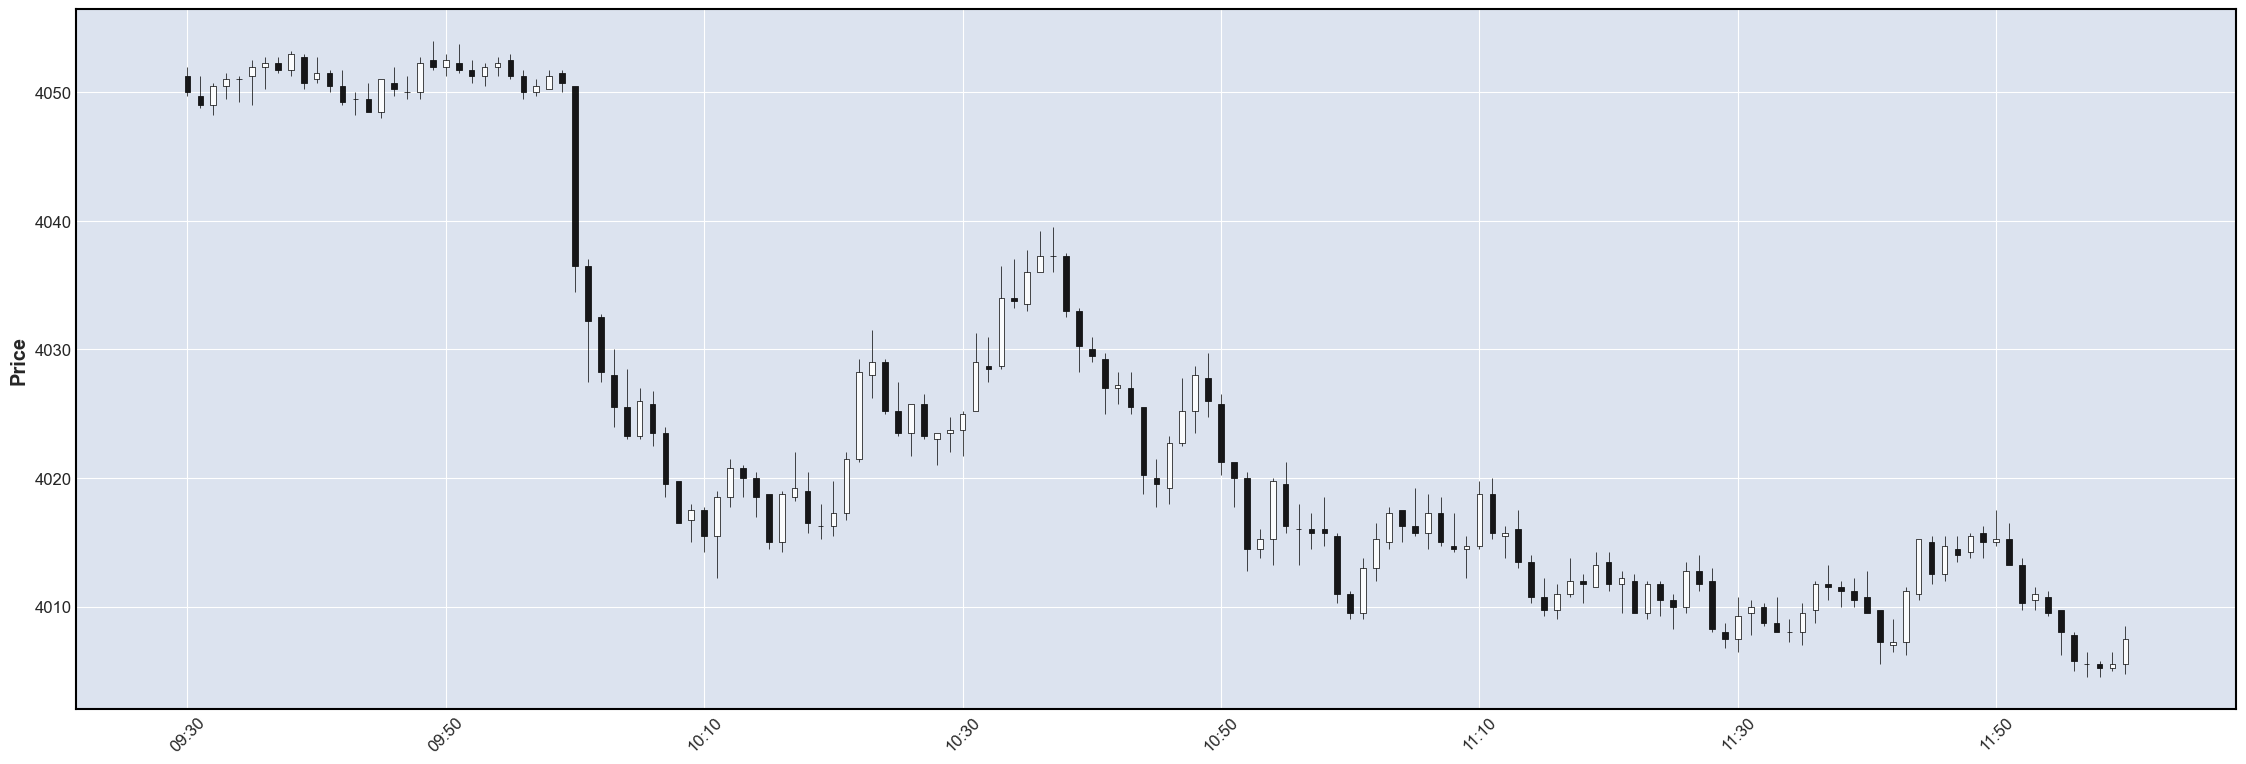

In [145]:
mpf.plot(temp2.dropna().loc['2023-03-07 9:30':'2023-03-07 12:00'], type='candle', figsize=(30,10))

In [146]:
temp2

,open,high,low,close,volume_es,swing_1T_es,swing_5T_es,swing_15T_es,swing_1H_es,swing_4H_es,...,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,day_of_week_sin,day_of_week_cos,weekly_open,weekly_close,daily_open
datetime,,,,,,,,,,,,,,,,,,,,,
2017-05-21 18:00:00-04:00,2381.75,2382.25,2381.00,2382.00,1632,0.0,0.0,0.0,0.0,0.0,...,-0.440394,-0.979084,0.203456,0.000000,1.000000,-2.449294e-16,1.0,2381.75,0.0,2381.75
2017-05-21 18:01:00-04:00,2381.75,2382.00,2381.75,2381.75,209,0.0,0.0,0.0,0.0,0.0,...,-0.440394,-0.979084,0.203456,0.104528,0.994522,-2.449294e-16,1.0,2381.75,0.0,2381.75
2017-05-21 18:02:00-04:00,2382.00,2382.75,2382.00,2382.50,766,0.0,0.0,0.0,0.0,0.0,...,-0.440394,-0.979084,0.203456,0.207912,0.978148,-2.449294e-16,1.0,2381.75,0.0,2381.75
2017-05-21 18:03:00-04:00,2382.50,2383.25,2382.25,2383.00,824,0.0,0.0,0.0,0.0,0.0,...,-0.440394,-0.979084,0.203456,0.309017,0.951057,-2.449294e-16,1.0,2381.75,0.0,2381.75
2017-05-21 18:04:00-04:00,2383.25,2383.25,2382.75,2383.25,640,0.0,0.0,0.0,0.0,0.0,...,-0.440394,-0.979084,0.203456,0.406737,0.913545,-2.449294e-16,1.0,2381.75,0.0,2381.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-20 16:55:00-04:00,4246.25,4247.00,4246.00,4246.50,284,1.0,0.0,0.0,0.0,0.0,...,-0.612106,-0.942261,-0.334880,-0.500000,0.866025,-8.660254e-01,-0.5,4356.75,4310.5,4296.50
2023-10-20 16:56:00-04:00,4246.75,4246.75,4245.75,4245.75,228,0.0,0.0,0.0,0.0,0.0,...,-0.612106,-0.942261,-0.334880,-0.406737,0.913545,-8.660254e-01,-0.5,4356.75,4310.5,4296.50
2023-10-20 16:57:00-04:00,4246.00,4246.25,4245.75,4246.25,199,1.0,0.0,0.0,0.0,0.0,...,-0.612106,-0.942261,-0.334880,-0.309017,0.951057,-8.660254e-01,-0.5,4356.75,4310.5,4296.50
